# *Think like a Bayesian, check like a frequentist*

**Task**:

a. Create yet again a **SIRD** model, including **D**eaths, **I**nfected, **R**ecovered and **S**usceptibles. While doing so fix $\gamma = 1$ and also $\beta = 2.5$.

b. Infer $\mu$ from the given input curves.

# Magic Commands in Jupyter
Jupyter notebooks have something called "magic commands". These are commands which are prefixed with a `%`, such as `%lsmagic`, which lists all magic commands. These commands set certain commands. The most common example is probably `%matplotlib inline` which tells `matplotlib` to plot all of its plots inside the Jupyter notebook. Another noteworthy point is that these magic commands can be used for specific cells or for the entire notebook. If one wants only to execute a magic command on one cell, then one must prefix the command with `%%` signs. This can also be used to program JavaScript or HTML inside a cell. Here are all the magic commands available:

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

# Imports

First we import all the packages which we already know, and functions we have already used.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
from arviz.plots.plot_utils import xarray_var_iter
import warnings
warnings.filterwarnings("ignore") 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

# Theory

## Bayes

Later on in Chapter [`pymc3`](#pymc3) we will talk about probabilistic programming for implementing Bayesian models [2]. But what is Bayesian? What makes it so special and why is there a package which explicitly states it can only be used for **Bayesian** models? This small chapter will elaborate on the differences between the different philosophies in statistics, before also delving deeper into Bayesian statistics.

### Bayesian vs. Frequentist

Imagine someone is going to the store and buys 100 bags of M&Ms. He opens a bag and whenever he eats a M&M he notes down the colour. After finishing all 100 bags of M&Ms he concludes that he had 30% of his M&Ms were red, 20% were green, 25% were blue and 35% were yellow. From a frequentist's perspective, this is the **prior**; the knowledge was obtained by the frequent and repeated sample of measuring. Hence that person expects a similar colour distribution the next time that he buys M&Ms. This connects **probabilites deeply to the frequency of events** [4].

In a Bayesian world that is different. For example, say you are about to eat M&Ms for the first time in your life and you are asked what you expect the colour distribution to be. Following a Bayesian perspective you might assert, "well, I walked through the park today and saw a lot of green trees, so 40% green, each tree had some (red) apples, so 25% red, the sun was shining, so 15% yellow and when I came home it started pouring down on me, hence 20% of the M&Ms will be blue." That analogy shows that "**probabilites are fundamentally related to our own knowlegde about an event**" [4]. 

This **prior** estimation of $\theta$ is a huge topic of debate. (Subjective) Bayesians say it is subjective, what would result in always different outcomes. Others say, we must first check it and then base it on frequency. Or maybe everything is subjective and so all models are different, just that some of them are actually useful [1]. Just think of the data you chose, the model you want to use etc. Those decisions are all based on subjectivity. The pragmatic solution which was found was, that if the sample size is just big enough the selected starting value for $\theta$ does not matter anymore, since all $\theta$s will converge all to the same value. Keep that in mind as you continue reading, as later on we will simplify Bayes' rule to something along those lines $p(\theta|y) \propto L(\theta)p(\theta)$; no matter how you choose $p(\theta)$, if your sample size is big enough $L(\theta)$ will dominate.

### Bayes' rule

Bayes' rule is the core or Bayesian statistics. Here's how it looks:

\begin{equation}
\color{orange}{P(A|B)} = \frac{\color{red}{P(B|A)}\color{green}{P(A)}}{\color{magenta}{P(B)}}
\end{equation}

In order to better explain the various parts of that equation, I want to introduce an analogy. Imagine you are a detective coming to a crime scene and you must determine who the perpetrator was.[<sup>1</sup>](#fn1)

- $\color{green}{P(A)}$: So when you arrive at the crime scene you already have a pretty good idea who the perpetrator is, based solely on your intuition. Hence, this part is called **prior**. It describes the probability of $\color{green}{A}$ before we have data. Meaning, before we have considered any evidence.
- $\color{orange}{P(A|B)}$: This is what we need to figure out. Based on all the data we have, who exactly did it? Or statistically speaking, what is the probability of $A$ given our data $B$. This part is called the **posterior**.
- $\color{magenta}{P(B)}$: This is the probability for our given data.
- $\color{red}{P(B|A)}$: This is the likelihood function. The likelihood function is the probability of data given the parameter, but as a function of the parameter holding the data fixed [1, 3].

Now we could read our Bayes' rule like so:

\begin{equation}
Posterior\ =\ \frac{Likelihood\ x\ Prior/Believe}{Evidence}
\end{equation}

The main idea is that we can update our beliefs with that model. In statistics we can call this **sequentialism**. Continuing with the detective analogy, that means that if/when the detective finds new evidence on the scene or finds out what happened beforehand, that information can be incorporated into our determination of who the perpetrator was (specifically the likelihood a given candidate was responsible for the crime). This is an iterative process and can be repeated continuously; everytime the **posterior** (the belief) of who did it is updated (updated here can either mean that the probability that someone did it increases or decreases). So lets imagine the detective arrives at a crime scene and sees three pieces of evidence. He could just update his belief once, using each of these three pieces of evidence; Bayes' rule **sequentially** incorporates these three pieces of evidence. Meaning we find one piece of evidence and update our beliefs (our **posterior**) accordingly. Next, we will find the second piece of evidence, and what happens now is that our **posterior** which we just calculated based on evidence one, becomes our new **prior**, and so on.

Lets do this again step by step. We arrive at a crime scene with all our experience $\color{green}{P(A)}$.

\begin{equation}
\color{orange}{P(A|B)} = \frac{P(B|A)\color{green}{P(A)}}{P(B)}
\end{equation}

Now we find our first piece of evidence $P(B)$, and we update our belief accordingly.

\begin{equation}
\color{red}{P(A|B)} = \frac{P(B|A)\color{orange}{P(A)}}{P(B)}
\end{equation}

And with the third piece of evidence we will update our beliefs again.

\begin{equation}
\color{blue}{P(A|B)} = \frac{P(B|A)\color{red}{P(A)}}{P(B)}
\end{equation}

This is going on and on with every new piece of evidence we find. As the lecturer indicates in [1], *our **posterior** tonight is our **prior** tomorrow*. In a more statistical version, this function can be written as:

\begin{equation}
\color{orange}{P(\theta|y)} = \frac{P(y|\theta)\color{green}{P(\theta)}}{\color{magenta}{P(y)}}
\end{equation}

This is nothing different than the above. Our data (here $y$) and our unknowns (here $\theta$). Essentially, we want to get our unknowns ($\theta$s) given our knowns (our data $y$). In order to calculate that, we can first get rid of $\color{magenta}{P(y)}$. Since we already have the data, we can treat it as fixed (since what should change on already gathered data?). So we can get rid of the denominator. However, $\theta$ is what we do not know. How can we derive something we do not know? The idea is to give it some kind of distribution, hence, our unknowns can be quantified using probabilites.[<sup>2</sup>](#fn2) With that in mind we can transform our original equation to:

\begin{equation}
p(\theta|y) \propto L(\theta)p(\theta)
\end{equation}

First we want to point out a property of the Bayes' rule. It states that "*the **posterior** density is proprotional (denoted as $\propto$) to the likelihood function times the **prior** density*" [1]. In statistical terms the likelihood function just means a function of $\theta$ given data $y$. A good example is statistical inference. We have some data (lets say about speeding) and we want to know, what are certain parameters ($\theta$s) that can form a prediction as to the likelihood regarding whether or not a person is speeding? 


---
<span id="fn1"><sup>1</sup>The idea of this analogy was taken from [1], lecture 16.</span><br>
<span id="fn2"><sup>2</sup>A really good quote here is: "*[...] probability is our best language to quantify uncertainty*", from [1], lecture 16.</span>

## Markov Chain

The Markov chain is the idea to define a "state space" and provide probabilites regarding how likely it is that a state be changed. Lets review the so-called "Baby" example [5].

![Markov Chain](./Markov_Chain.png)

Here we can see we have three different states: crying, laughing and sleeping. The baby can go from one state to another with a certain probability, it can also stay where it is right now, again with a given probability. Let's represent that with a matrix:

\begin{equation}
Baby = \left( \begin{matrix} \color{orange}{0.5} & \color{red}{0.25} & \color{ForestGreen}{0.25} \\ \color{orange}{0.4} & \color{red}{0.3} & \color{ForestGreen}{0.3} \\ \color{orange}{0.15} & \color{red}{0.15} & \color{ForestGreen}{0.7} \end{matrix} \right)
\end{equation}

A nice property of the Markov chain is, its *memorylessness*. That means, it does not matter how exactly you got where you are right now; only the last state matters. So, if the baby is sleeping and is to move to a laughing state, only the fact that the baby is currently sleeping (and not what the baby was doing before sleeping) is pertinent.

# Key Properties of Markov Chains
**Note**: Normalization, Ergodicity, and Homogeneity are *general properties*, whereas Reversibility is a *special property*. A general property is one that is typically assumed to be true unless specified/proved otherwise, while the opposite is the case for special properties.


### Normalization
For each state, the transition probabilities sum to 1.

### Ergodicity
Ergodicity expresses the idea that a point of a moving system, either a dynamical system or a stochastic process, will eventually (i.e. in a finite number of steps and with a positive probability) visit all parts of the space that the system moves in, in a uniform and random sense [Class Notes, 8].

### Homogeneity
A Markov chain is called homogeneous if and only if the transition probabilities are independent of the time [9].

### Reversible 
Reversibility is obtained if the chain is symmetric, meaning that running it backwards is equivalent to running it forwards.

## Monte Carlo

The Monte Carlo method is based on the law of big numbers, viz. if we do something just often enough, overall we will have an average outcome. The advantage of this method is that it returns values and their probabilities for a given problem. The Monte Carlo method can be used for estimating $\pi$ or for the falling of a raindrop. It does that through repeatedly picking random samples and recalculating it for each sample.

## Markov Chain Monte Carlo (MCMC)

Recall that our main goal is to estimate our posterior by updating our priors (beliefs). Let's say that we want to predict an outcome given two input parameters. If we assume that they are uniformly distributed (this is what the user has to provide, since this tells the algorithm how our **priors** are distributed) from 0 to 5, then we would have a graphic like the one below.

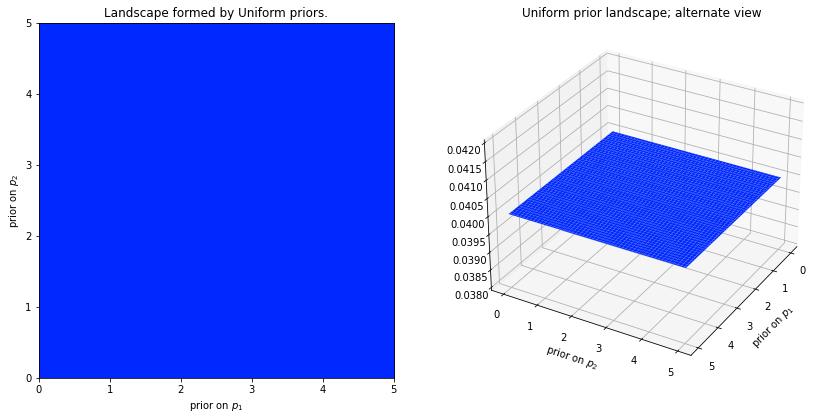

In [3]:
# This code comes from: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(14, 14)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("Uniform prior landscape; alternate view");

What we can see here is that each point in the plan currently has the exact same likelihood; that is what makes it is a plan. We could have also decided that our **priors** are exponetials. In that case the likelihood for certain parameters would look like this:

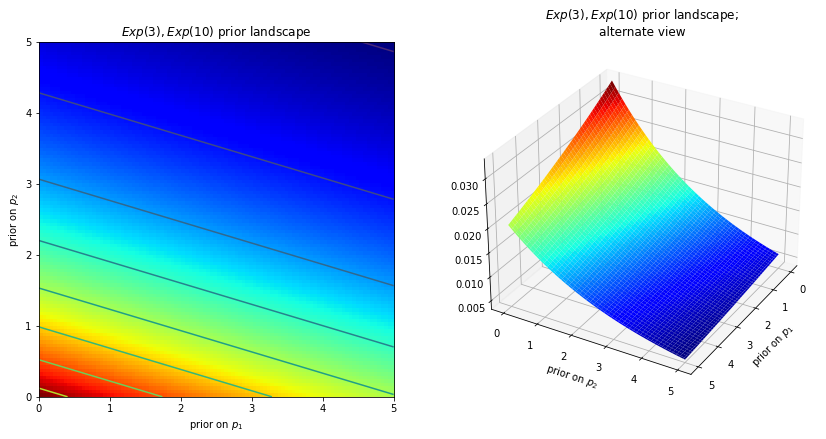

In [4]:
# Code comes from: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb

figsize(14, 14)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

Where we can clearly see that some parameters are more likely than others. *If these surfaces describe our prior distributions on the unknowns, what happens to our space after we incorporate our observed data X? The data X does not change the space, but it changes the surface of the space by pulling and stretching the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the posterior distribution.*

*Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially pushes up the original surface to make tall mountains. The tendency of the observed data to push up the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there.* (this is directly copy pasted from [6])

# The SIRD Model

In [5]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
d0 = 0.00 # fraction of dead at time t0=0
f = 3.0 # time factor, defines total time window range
timestep_data = 0.5 # dt for data (e.g., weekly)
times = np.arange(0,5*f,timestep_data) #np.array from 0 to 15 with steps of 0.5
#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5
#Mortality Rate
mu = 0.1

In [6]:
def SIRD(y, t, p):
    """"This function alters the SIR model from Epidemiology in order to incorporate the deaths 
    caused by the disease.
    
    Parameters:
    ----------
    y: np.array
        This array contains the initial values of r0, i0 an d0. The parameter r0 represents the fraction of 
        recovered people at time t0=0, whereas i0 and d0 representes the fraction of infected and dead 
        people at time t0=0 .
    t: np.array
        This array contains the points in time, where i0, r0 and d0 are modelled.
    p: np.array 
        This array contains the following values in a list:
            beta: float
                The contact rate, more specifically the number of lengthy
                contacts a person has per day.
            mu: float
                The mortaltiy rate.
    """
    # Unpack y to Initial values for the recovered, infected and dead
    #  R = y[0]
    #  I = y[1]
    #  D = y[2]
    # Calculate S
    S = 1 - y[0] - y[1] - y[2]
    # Gamma is set to equal 1
    gamma = 1 
    # Change of Infections
    dIdt = p[0] * S * y[1] - gamma * y[1] - p[1] * y[1]
    # Change in Recovered
    dRdt = gamma * y[1]
    # Change in Deaths
    dDdt = p[1] * y[1]
    # Return Recovered, Infected and Death
    return [dRdt, dIdt, dDdt]

In [7]:
# Create SIRD curves
y = odeint(SIRD, t=times, y0=[r0, i0, d0], args=tuple([[beta,mu]]), rtol=1e-8) # r0 recovered, i0 infected  at t0

Next we start to create some noise around our dataset. The different $\sigma$s are displayed below. In the end we sample noisy points from our data derived from our partial derivatives. The following $\sigma$s are setting the noise for each compartment. 

In [8]:
# Observational model for muliplicative noise
sigma_R = 0.10
sigma_I = 0.20
sigma_D = 0.40
sigma = [sigma_R, sigma_I, sigma_D]
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=sigma) # noise is multiplicative (makes sense here)

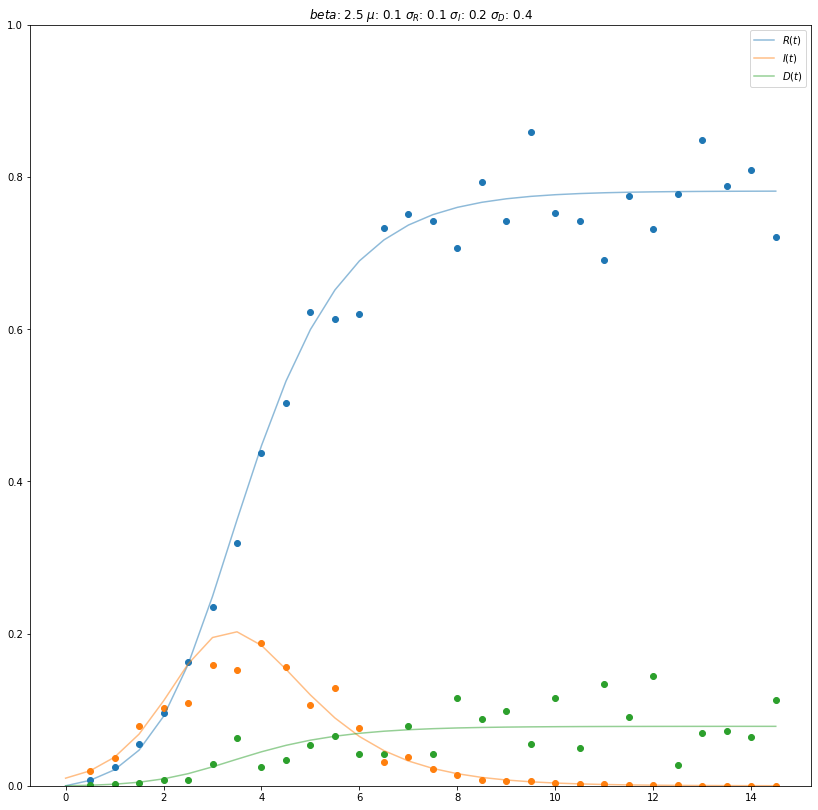

In [9]:
# Plotting
# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.title('$beta$: ' + str(beta) + ' $\mu$: ' + str(mu) + ' $\sigma_R$: ' + str(sigma[0]) + ' $\sigma_I$: ' +str(sigma[1]) + ' $\sigma_D$: ' +str(sigma[2]))
plt.legend()
plt.ylim(0,1)
plt.show()

Here we can see, the dots, which are displaying the noisy data, and the lines which display the data from the partial derivatives.

With the introduction of noise to the data, i.e. through $\sigma_{Recovered}$, $\sigma_{Infected}$ and $\sigma_{Dead}$, individual data points may exceed the value of 1.0. Furthermore, for a certain point in time the sum of $R(t)$, $I(t)$ and $D(t)$ may exceed the amount of 1.0. This contradicts reality as the size of the population can not exceed 100%, i.e. 1. Thus, the compartments *recovered*, *infected* and *dead* should maximally yield a sum of 1, which in turn corresponds to the amount of *suceptibles* being 0. In order to address this issue, the modelling of noise would need to be adjusted, e.g. by introducing a constraint. As this did not significantly effect the second part of our assignment, we did not chose to alter the modelling of noise. Nevertheless, it is important to keep this shortcoming in mind if applied to other tasks.

In the next step we are building our differential equation. Bear in mind that we have to pass as many `n_states` as compartments we have (`deaths`, `recovered` & `infected`). The parameter `n_theta` specifies the number of parameters the model takes into account. This is here `mu` and `beta`.

In [10]:
# ODE system container
sird_model = DifferentialEquation(
    func = SIRD,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #r(ecovered) and i(nfected) and d(ead) are states
    n_theta = 2, # beta=R0 and mu only parameter
    t0 = 0, # start from zero
)

To create a Markov Chain Monte Carlo, we have to set some **prior** values and distributions. Overall, we have two values which should be estimated by the MCMC, namely $\mu$ and $R_{nought}$.

## $\mu$

For the $\mu$ we chose a normal distribution which has a lower bound at `0`. Since $\mu$ describes the death rate, it would not make to much sense to have a negative death rate. However, one could argue that even a negative death rate could make sense, since people are more at home during a pandemic and spending more time together and thus "creating" more children. Although we do not account for that here. This is in line with the general SIRD model which also does not account for birth or other reasons of death. For this normal distribution we decided to chose a value of `0.1`, since this would equal a death rate of 10% meaning that on average 10% of the infected population on a given day (or more generically per unit of time) dies. The next parameter we chose is the standard deviation of that normal distribution. Here we selected `0.03`, as that seemed a reasonable range for the death rate. Now the death rate ranges between 1% and 20%. We highly doubt that a death rate above 20% is realistic. Hence:

In [11]:
mu_lower_bound = 0
mu_mean = 0.1
mu_sd = 0.03

## $R_{nought}$

For $R_{nought}$ we chose a normal distribution, which has a lower bound at `1`. The reason is that the $SIRD$ model is an epidemic model. An epidemic is constituted by a value of the basic reproduction number ($R_{nought}$) from greater or equal to one. As the mean of this normal distribution we chose `2.27`, since that seemed like a reasonable value and a standard deviation of `0.4`. This also corresponds to our assumption of `0.1` for the death rate: 

$$
R_{nought} = \frac{\beta}{\gamma + \mu} = \frac{2.5}{1+0.1}
$$


Now the normal distribution ranges between 1.07 and 3.5.

In [12]:
R0_lower_bound = 1
R0_mean = 2.27
R0_sd = 0.4

In [13]:
# Create the model
basic_model = pm.Model()

# Customize the model
with basic_model:
    # The with ... syntax allows us to now give the model certain attributes.
    
    # Distribution of variances, sigma[0] and sigma[1], sigma[2] some good choice, pos. chauchy 
    # Here we are setting a random variable named "sigma" and its random distribution,
    # which we set as HalfCauchy (see docstring for example of plotting). Since
    # we want to predict 3 different values I, R, D we need a 3D shape.
    sigma = pm.HalfCauchy('sigma', 1, shape = 3)
    
    # Next we want to set our normal distribution. In order to do that, we need to
    # bound it, so that it is always above 1, because that is the reasoning for an epidemic
    # to occure. The background for this is, that the parameter
    # R nought, should not be below 1.
    R0 = pm.Bound(pm.Normal, lower = R0_lower_bound)('$R_{nought}$', mu = R0_mean, sd = R0_sd)

    # We also need to create something like this for the death rate mu. The only
    # difference is, that it cannot fall below 0.
    # 0.1 is the mu, our current death rate
    # 0.3 is the standard deviation, and it determines the shape of our curve. All values greater than
    # one flatten the curve.
    mu = pm.Bound(pm.Normal, lower = mu_lower_bound)('$\mu$', mu = mu_mean, sd = mu_sd)
    
    # We now need to set up our model. Remember that we want to try and find the parameters
    # for the death compartment.
    # y0 is an array of the parameters for the SIRD function.
    sird_curves = sird_model(y0 = [r0, i0, d0], theta = [R0, mu])
    
    # Now we need to set up the prediction of the posterior, our Y. This function
    # takes different values. Once the mu, which describes the "location parameter". Once
    # the standard deviation sd, which is defined by our sigmas, and once our
    # created noisy observances.
    Y = pm.Lognormal('Y', mu=pm.math.log(sird_curves), sd=sigma, observed=yobs)
    
    # Having completely specified our model, the next step is to obtain posterior
    # estimates for the unknown variables in the model. Ideally, we could calculate
    # the posterior estimates analytically, but for most non-trivial models, this is
    # not feasible. The maximum a posteriori (MAP) estimate for a model, is the
    # mode of the posterior distribution and is generally found using numerical
    # optimization methods. (https://docs.pymc.io/notebooks/getting_started.html) 
    start = pm.find_MAP()
    
    # The No U-Turn sampler is the state of the art sampler
    step = pm.NUTS()
    
    # Finally we initiate the smapler, using 1000 samples.
    trace = pm.sample(1000, random_seed=44)
    
    # Lastly, we transform our data into proper data for the arviz package
    # so that we can use some of its features to make nicer plots.
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\mu$, $R_{nought}$, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 987 seconds.


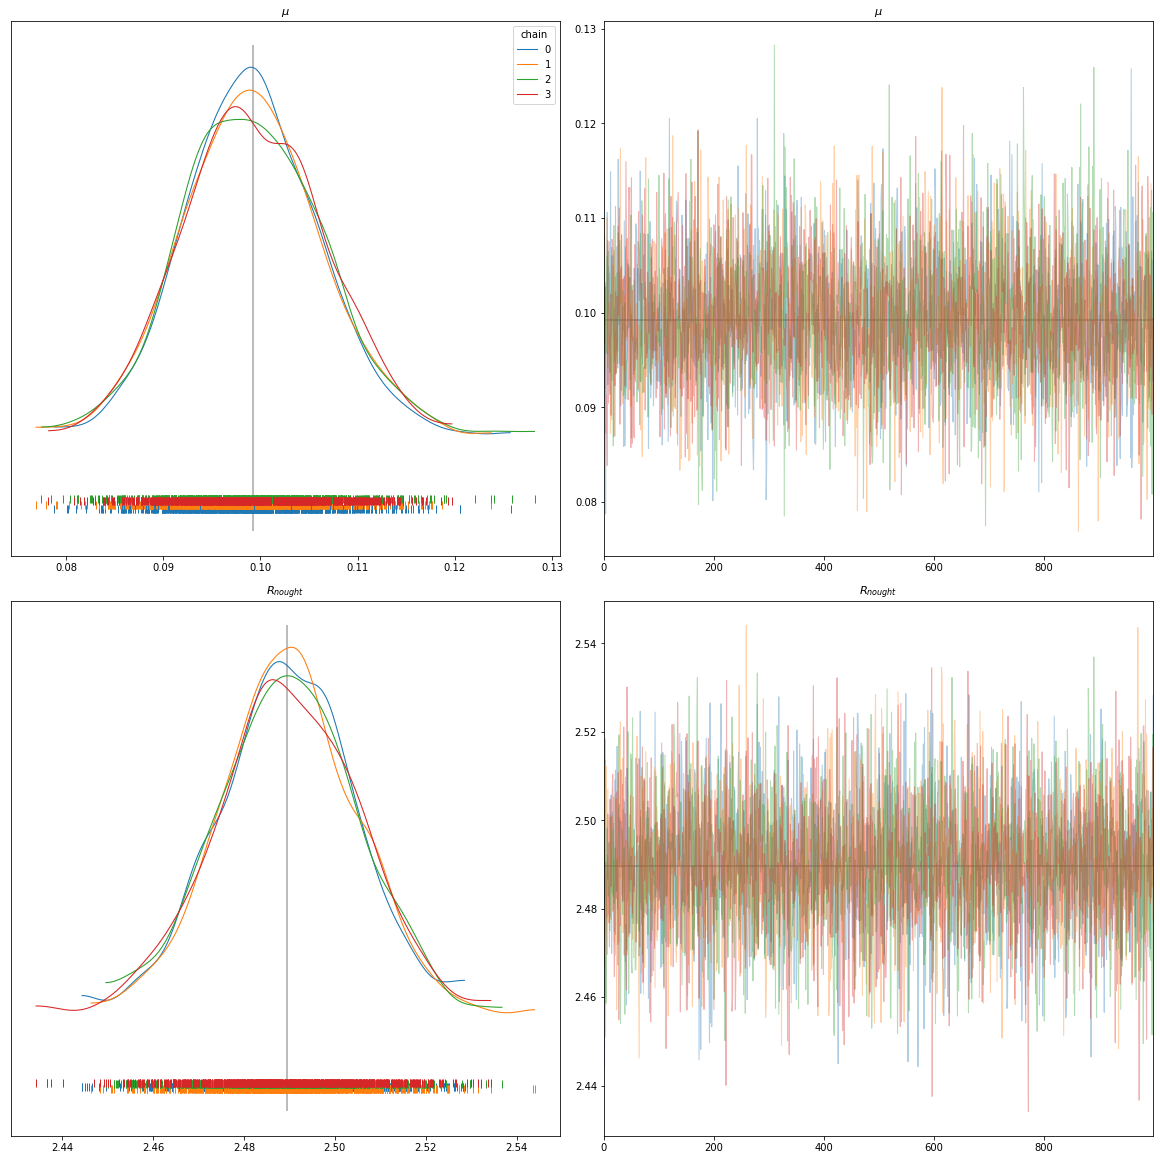

In [14]:
# The idea of inputing the lines like this is take from [7]
var_names = ["$\mu$", "$R_{nought}$"]
lines = list(xarray_var_iter(data.posterior[var_names].mean(dim=("chain", "draw"))))

# Plot results (takes a while, be patient)
az.plot_trace(data,
              var_names = var_names,
              figsize = (16, 16),
              rug=True,
              lines = lines,
              legend = True,
              combined = False,
              compact = False)
plt.show()

**In general**:

On the left hand side, we have the different Kernel Density Estimation plots. Those are plots which are effectively just a smoothed version of a histogram. They give us information about where our model has the most frequent values for a given parameter. On the right hand side, we have a trace plot. The trace plot shows which value was predicted for each iteration.

**Use case SIRD**:

In the bottom of each of the left graphics we can see the distributions, viz. how often each value occurred over all chains and samples. Hereby, the different colors refer to the different chains. Logically, the mean has the most dense distribution. One can now clearly see, that the distribution of the observed data is between 0.08 and 0.12 for $\mu$ and between 2.44 and 2.54 for $R_{nought}$. These values could now be used to build a new model.

On the right hand side of these plots we see the trace plots of the different chains. We can see, that the y-values for each plot is quite small. This is a good indicator, that our model converged quite quickly, however testing still other values and not getting stuck on either local minima or maxima.

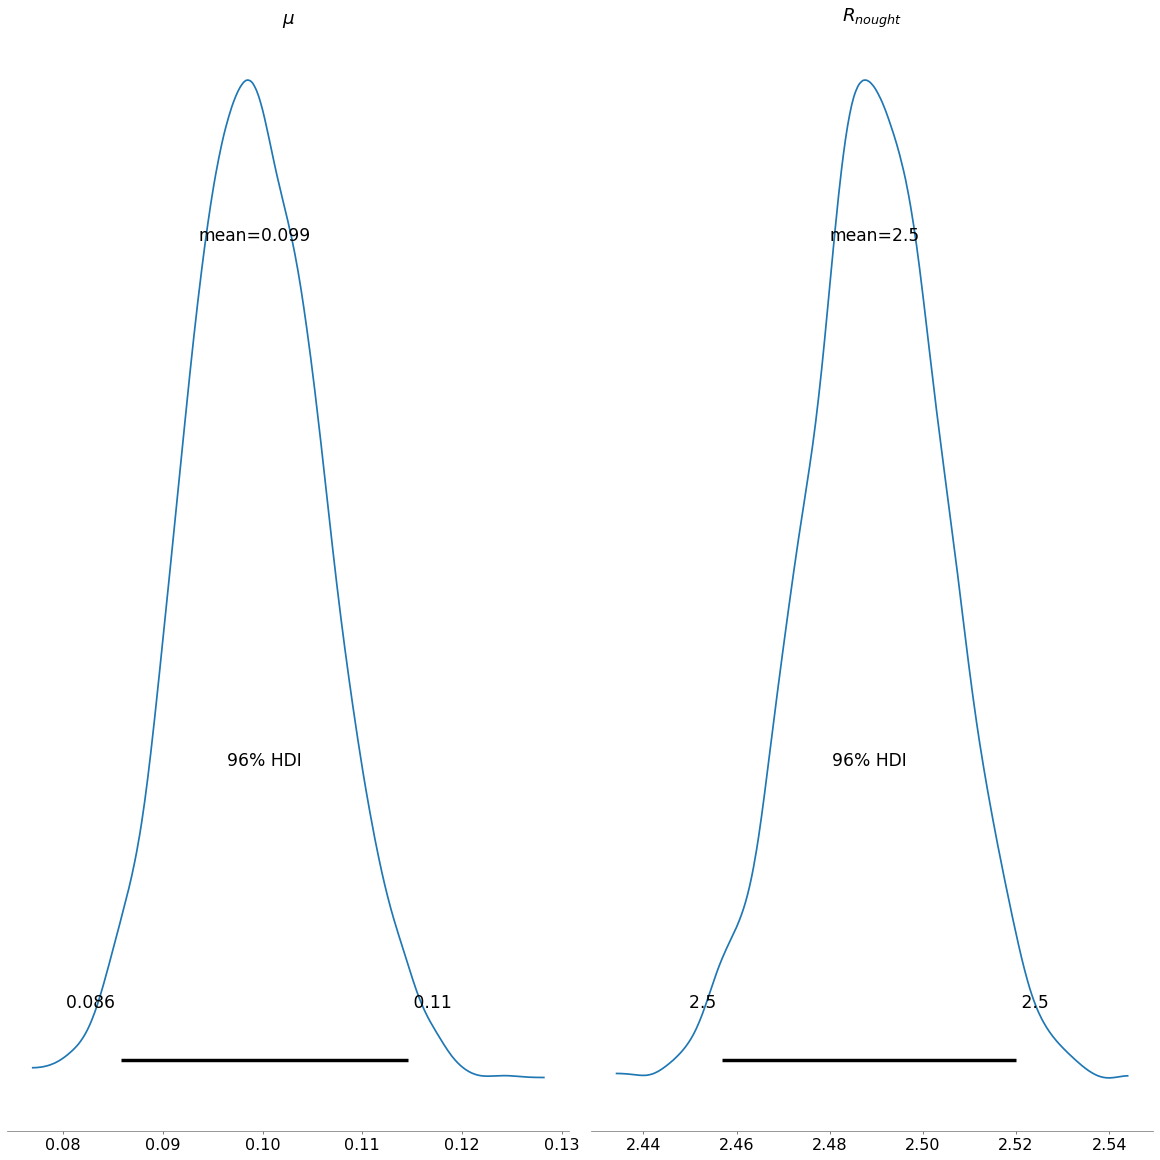

In [15]:
# Plot results (takes a while, be patient)
az.plot_posterior(trace,
                  figsize=(16,16),
                  var_names = var_names,
                  textsize = 16,
                  hdi_prob = 0.96)
plt.show()

The posterior plot shows us, the general combined distribution of our estimated posteriors for the respective values of $\mu$ and $R_{nought}$. For $\mu$ we can see, that values between 0.086 and 0.11 are the most credibile values. For $R_{nought}$ the range is 2.45 and 2.53. 

In [27]:
az.summary(data,
           var_names = var_names,
           round_to = 4,
           hdi_prob=0.96)

,mean,sd,hdi_2%,hdi_98%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\mu$,0.0992,0.0070,0.0858,0.1145,0.0001,0.0001,4894.1475,2983.8767,1.0012
$R_{nought}$,2.4896,0.0152,2.4569,2.5200,0.0002,0.0001,5874.9996,3400.2764,1.0002


Finally, it is worthwhile to review the summary statistics for our findings. As shown in the plots above, $\mu$ has a mean of `0.1` and $R_{nought}$ has a mean of `2.49`. Our prior belief for the mean $\mu$ was `0.1`, while it was `0.03` for the standard deviation. When running the model, the mean decreased slightly to `0.0992`, whereas the standard deviation decreased substantially to `0.007`. Regarding $R_{nought}$, the prior belief changed from `2.27` to `2.49`, and its standard deviation decreased from `0.4` to `0.0152`.

# Bibliography

[1] https://cs109.github.io/2015/

*Note: This source is an amazing source for introductry to advanced topics in machine learning. They give really good advices on which books to read (which are mostly free available on the web) and they explain a lot of topics, so that they are understandable. This is a recommend source to read/listen to!*

[2] https://docs.pymc.io/about.html

*Note: Nice introduction to the package `pymc3`, since it goes from building a basic linear model to more detail about the different functions. The only downside is, that it is not really explaining the graphs and what excatly they are depicting.*

[3] http://www.medicine.mcgill.ca/epidemiology/hanley/bios601/Likelihood/Likelihood.pdf

*Note: On page two is a really good example for the likelihood function.*

[4] https://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

*Note: This is a really good introduction into the topic covered in chapter 1.2. It delves a lot more deeper into that topic that what was outlined here. Moreover, it was written by Jake Vanderplas who is a well know author and developer or the scipy Python package.*

[5] https://setosa.io/ev/markov-chains/

*Note: A really good and easy reading for understand Markov chains, it has some really nice JS implementation, which can be played around with.*

[6] https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/

*Note: Easy and accessible explanation of Bayes using Python.*

[7] https://oriolabril.github.io/oriol_unraveled/python/arviz/matplotlib/2020/06/20/plot-trace.html

*Note: Nice website, which shows was options the `pm.traceplot` function has and how to use them.*

[8] University of Wisconson: https://people.math.wisc.edu/~valko/courses/331/MC2.pdf

[9] Texas A&M University: https://people.engr.tamu.edu/andreas-klappenecker/csce658-s18/markov_chains.pdf

---
# Reading list

- https://peerj.com/articles/cs-55/
    *Note: Good introduction into probabilistic programming using `pymc3`.*

- https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/
    *Note: same as above*

- https://allendowney.github.io/ThinkBayes2/
    *Note: Good book on Bayesian thinking
    
- https://harvard-iacs.github.io/2020-CS109B/labs/lab04/notebook/ *Note: Check out the lab works evolving around `pymc3` and MCMC